In [1]:
!pip install -U transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 47.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.12.0
    Uninstalling huggingface-hub-0.12.0:
      Successfully uninstalled huggingface-hub-0.12.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.21.3
    Uninstalling transformers-4.21.3:
      Successfully uninstalled transformers-4.21.3


In [2]:
!pip install datasets
!pip install soundfile
!pip install librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 52.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 61.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 33.8 MB/s eta 0:00:0000:0100:01
  Created wheel for audioread: filename=audioread-3.0.0-py3-none-any.whl size=23702 sha256=9010447b99a7ff48e3a2120ab39cd45eecc9d2c79158ee51098bb0d95670f239
  Stored in directory: /root/.cache/pip/wheels/7a/6a/b0/92760a6d6bc2bff5464970af910c0b0b921390993f3199cdf7
Successfully built audioread


In [3]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-xywebhqk
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-xywebhqk
  Resolved https://github.com/huggingface/transformers to commit abaca9f9432a84cfaa95531de4c72334f38a42f2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.31.0.dev0-py3-none-any.whl size=7286950 sha256=6234530d1c93cb72f5221895284f9f48d64fc67db2a0f439e86cf16a0b65b6b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-z9bv7e22/wheels/14/a0/7b/8f6b25ba4110aa215fcb8d6aedd6cd4f9b9b6619190999ac2b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2


In [4]:
!pip install speechbrain accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.0/519.0 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 kB 60.0 MB/s eta 0:00:00


In [53]:
!apt-get install git-lfs
!git lfs install

## Pre-trained models for text-to-speech

#### SpeechT5

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

In [ ]:
inputs = processor(text="Don't count the days, make the days count", return_tensors="pt")

In [ ]:
# load speaker embedding
from datasets import load_dataset
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")


In [ ]:
import torch
speaker_embeddings = torch.tensor(embeddings_dataset[6306]["xvector"]).unsqueeze(0) # change which voice here

In [ ]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

In [ ]:
# load vocoder to generate audio from log mel spectrogram
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [ ]:
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [ ]:
import IPython
IPython.display.Audio(speech, rate=16_000)

#### Massive Multilingual Speech (MMS)

In [7]:
#not merged yet so install from branch
!pip install -U git+https://github.com/hollance/transformers.git@vits

  Cloning https://github.com/hollance/transformers.git (to revision vits) to /tmp/pip-req-build-0gh6bqwp
  Running command git clone --filter=blob:none --quiet https://github.com/hollance/transformers.git /tmp/pip-req-build-0gh6bqwp
  Running command git checkout -b vits --track origin/vits
  Switched to a new branch 'vits'
  Branch 'vits' set up to track remote branch 'vits' from 'origin'.
  Resolved https://github.com/hollance/transformers.git to commit 7c21aa2a091bbae0f1b5eca82590287a28c6f555
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [10]:
from transformers import VitsModel

ImportError: cannot import name 'VitsModel' from 'transformers' (/usr/local/lib/python3.9/dist-packages/transformers/__init__.py)

## Fine-tuning SpeechT5


### Housekeeping

In [6]:
from huggingface_hub import notebook_login

notebook_login()

### The dataset

In [7]:
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/voxpopuli", "nl", split="train")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [8]:
len(dataset)

20968

In [9]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

### Preprocessing the data

In [10]:
from transformers import SpeechT5Processor
checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

#### Text cleanup for SpeechT5 tokenization

In [11]:
tokenizer = processor.tokenizer

In [12]:
dataset[0]

{'audio_id': '20100210-0900-PLENARY-3-nl_20100210-09:06:43_4',
 'language': 9,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/02ec6a19d5b97c03e1379250378454dbf3fa2972943504a91c7da5045aa26a89/train_part_0/20100210-0900-PLENARY-3-nl_20100210-09:06:43_4.wav',
  'array': array([ 4.2724609e-04,  1.3122559e-03,  1.0375977e-03, ...,
         -9.1552734e-05,  7.6293945e-04, -2.4414062e-04], dtype=float32),
  'sampling_rate': 16000},
 'raw_text': 'Dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'normalized_text': 'dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'gender': 'female',
 'speaker_id': '1122',
 'is_gold_transcript': True,
 'accent': 'None'}

In [13]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab":[vocab], "all_text": [all_text]}

In [14]:
vocabs = dataset.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=dataset.column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [15]:
dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

In [16]:
# identify all special characters that tokenizer does not contain
dataset_vocab - tokenizer_vocab

{' ', 'à', 'ç', 'è', 'ë', 'í', 'ï', 'ö', 'ü'}

In [17]:
replacements= [
    ('à', 'a'),
    ('ç', 'c'),
    ('è', 'e'),
    ('ë', 'e'),
    ('í', 'i'),
    ('ï', 'i'),
    ('ö', 'o'),
    ('ü', 'u'),
]

In [18]:
# replace special characters
def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text)
    

  0%|          | 0/20968 [00:00<?, ?ex/s]

#### Speakers

In [19]:
from collections import defaultdict
speaker_counts = defaultdict(int)
for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1
    

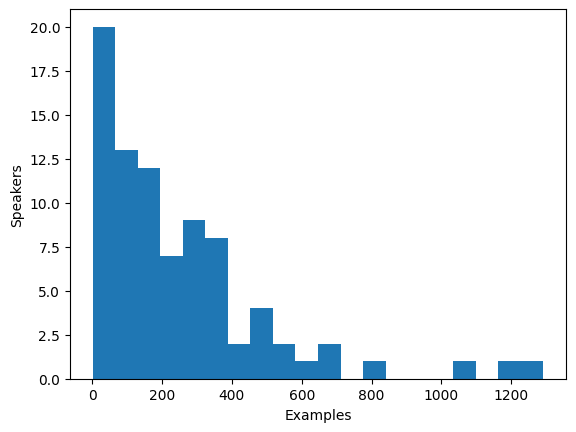

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [25]:
# balance dataset by limiting speakers to middle
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400
dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

  0%|          | 0/10 [00:00<?, ?ba/s]

In [26]:
len(set(dataset["speaker_id"]))

42

In [27]:
len(dataset)

9973

#### Speaker embeddings

In [28]:
# needed to differentiate between multiple speakers
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"
device = "cuda"
speaker_model = EncoderClassifier.from_hparams(source=spk_model_name, run_opts={"device":device}, savedir=os.path.join("/tmp", spk_model_name))

In [33]:
def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

#### Processing the dataset

In [34]:
def prepare_dataset(example):
    audio = example["audio"]
    example = processor(text=example["normalized_text"], audio_target=audio["array"], sampling_rate=audio["sampling_rate"], return_attention_mask=False)
    # strip off batch dimension
    example["labels"] = example["labels"][0]
    
    #use SpeechBrain to get x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])
    return example

In [37]:
# test with one example
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [38]:
# check embeddings shape
processed_example["speaker_embeddings"].shape

(512,)

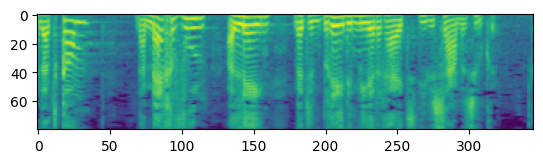

In [39]:
# check labels is log-mel spectrogram with 80 bins
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [40]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)
dataset

  0%|          | 0/9973 [00:00<?, ?ex/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 600). Running this sequence through the model will result in indexing errors


Dataset({
    features: ['input_ids', 'labels', 'speaker_embeddings'],
    num_rows: 9973
})

In [41]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200
dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

  0%|          | 0/10 [00:00<?, ?ba/s]

8259

In [42]:
dataset = dataset.train_test_split(test_size=0.1)

#### Data collator

In [43]:
# to combine multiple examples into a batch, you need to define a custom data collator. 
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [51]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

### Train the model

In [44]:
from transformers import SpeechT5ForTextToSpeech
model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [45]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [47]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [48]:
wandb.init(project="huggingface-audio-course-unit6", resume=True)

wandb: Currently logged in as: ptah23. Use `wandb login --relogin` to force relogin


In [62]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_nl",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=4,
    save_steps=100,
    eval_steps=100,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [63]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

/notebooks/speecht5_finetuned_voxpopuli_nl is already a clone of https://huggingface.co/ptah23/speecht5_finetuned_voxpopuli_nl. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


In [ ]:
trainer.push_to_hub()

### Inference